In [1]:
import os
from glob import glob 

os.environ["USE_PYGEOS"] = "0"

import dask
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50
plt.rcParams["font.size"] = 12

from matplotlib.colors import LinearSegmentedColormap

# cm_data = np.loadtxt("../utils/bamako.txt")[::-1]
# bamako_map = LinearSegmentedColormap.from_list("bamako", cm_data, N=10)

# cm_data = np.loadtxt("../utils/batlowW.txt")[::-1]
# batlow_map = LinearSegmentedColormap.from_list("batlowW", cm_data)

# cm_data = np.loadtxt("../utils/davos.txt")[::-1]
# alt_map = LinearSegmentedColormap.from_list("alt", cm_data, N=20)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import regionmask

## Preliminaries

In [4]:
# Paths
main_path = "/gpfs/group/kaf26/default/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/"

In [3]:
##############################
# UC map plot
##############################
def plot_uc_map(ds, var_id, weighted, scenario_id, axs, fig, cbar, title, fs):
    # Averaging periods
    early_start, early_end = 2025, 2035
    mid_start, mid_end = 2035, 2045
    late_start, late_end = 2045, 2055

    # Concat to 3 epochs
    ds_early = ds_uc.sel(time=slice(early_start, early_end))[var_id]
    ds_mid = ds_uc.sel(time=slice(mid_start, mid_end))[var_id]
    ds_late = ds_uc.sel(time=slice(late_start, late_end))[var_id]

    # Get 'total' uncertainty
    scenario_uncertainty = "scenario_" + scenario_id
    model_uncertainty = "model_" + ((not weighted) * "un") + "weighted"
    iv_uncertainty = "iv_" + ((not weighted) * "un") + "weighted"
    method_uncertainty = "method_" + ((not weighted) * "un") + "weighted"

    Utotal_early = (
        ds_early.sel(uncertainty=model_uncertainty)
        + ds_early.sel(uncertainty=scenario_uncertainty)
        + ds_early.sel(uncertainty=method_uncertainty)
        + ds_early.sel(uncertainty=iv_uncertainty)
    )
    Utotal_mid = (
        ds_mid.sel(uncertainty=model_uncertainty)
        + ds_mid.sel(uncertainty=scenario_uncertainty)
        + ds_mid.sel(uncertainty=method_uncertainty)
        + ds_mid.sel(uncertainty=iv_uncertainty)
    )
    Utotal_late = (
        ds_late.sel(uncertainty=model_uncertainty)
        + ds_late.sel(uncertainty=scenario_uncertainty)
        + ds_late.sel(uncertainty=method_uncertainty)
        + ds_late.sel(uncertainty=iv_uncertainty)
    )

    # Get fractions and average for each epoch
    Ufrac_model_early = 100 * (ds_early.sel(uncertainty=model_uncertainty) / Utotal_early).mean(dim="time")
    Ufrac_scenario_early = 100 * (ds_early.sel(uncertainty=scenario_uncertainty) / Utotal_early).mean(dim="time")
    Ufrac_method_early = 100 * (ds_early.sel(uncertainty=method_uncertainty) / Utotal_early).mean(dim="time")
    Ufrac_iv_early = 100 * (ds_early.sel(uncertainty=iv_uncertainty) / Utotal_early).mean(dim="time")

    Ufrac_model_mid = 100 * (ds_mid.sel(uncertainty=model_uncertainty) / Utotal_mid).mean(dim="time")
    Ufrac_scenario_mid = 100 * (ds_mid.sel(uncertainty=scenario_uncertainty) / Utotal_mid).mean(dim="time")
    Ufrac_method_mid = 100 * (ds_mid.sel(uncertainty=method_uncertainty) / Utotal_mid).mean(dim="time")
    Ufrac_iv_mid = 100 * (ds_mid.sel(uncertainty=iv_uncertainty) / Utotal_mid).mean(dim="time")

    Ufrac_model_late = 100 * (ds_late.sel(uncertainty=model_uncertainty) / Utotal_late).mean(dim="time")
    Ufrac_scenario_late = 100 * (ds_late.sel(uncertainty=scenario_uncertainty) / Utotal_late).mean(dim="time")
    Ufrac_method_late = 100 * (ds_late.sel(uncertainty=method_uncertainty) / Utotal_late).mean(dim="time")
    Ufrac_iv_late = 100 * (ds_late.sel(uncertainty=iv_uncertainty) / Utotal_late).mean(dim="time")

    # Plot
    if fig == False:
        fig, axs = plt.subplots(
            ncols=4,
            nrows=3,
            figsize=(16, 6),
            subplot_kw=dict(projection=ccrs.PlateCarree()),
        )
        axs = axs.flatten()

        fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.01)

    # List with all results
    Ufrac_all = [
        Ufrac_scenario_early,
        Ufrac_model_early,
        Ufrac_method_early,
        Ufrac_iv_early,
        Ufrac_scenario_mid,
        Ufrac_model_mid,
        Ufrac_method_mid,
        Ufrac_iv_mid,
        Ufrac_scenario_late,
        Ufrac_model_late,
        Ufrac_method_late,
        Ufrac_iv_late,
    ]

    # Loop through and make each plot
    axs = axs.flatten()
    for i in range(len(axs)):
        ax = axs[i]
        p = Ufrac_all[i].plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            vmin=0.0,
            vmax=100.0,
            levels=11,
            zorder=1,
            # cmap=bamako_map,
            cmap="Greens",
            add_colorbar=False,
        )
        # Area weighted mean
        weights = np.cos(np.deg2rad(Ufrac_all[i].lat))
        weights.name = "weights"
        area_weighted_mean = Ufrac_all[i].weighted(weights).mean()
        ax.text(
            0.11,
            0.18,
            "{:.0f}%".format(area_weighted_mean),
            fontsize=fs - 1,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="silver", edgecolor="silver", alpha=0.5, pad=2),
            zorder=200,
        )
        # Other features
        ax.add_feature(cfeature.OCEAN, zorder=2, linewidth=0.001, color="white")
        ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
        ax.add_feature(cfeature.STATES, linewidth=0.4)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        ax.set_title("")
    # Set titles
    axs[0].set_title("Scenario uncertainty", fontsize=fs)
    axs[1].set_title("Model uncertainty", fontsize=fs)
    axs[2].set_title("Downscaling uncertainty", fontsize=fs)
    axs[3].set_title("Internal variability", fontsize=fs)

    # axs[0].text(
    #     -185,
    #     15,
    #     "2020-2039",
    #     va="bottom",
    #     ha="center",
    #     rotation="vertical",
    #     rotation_mode="anchor",
    #     fontsize=fs,
    # )
    # axs[4].text(
    #     -185,
    #     15,
    #     "2050-2069",
    #     va="bottom",
    #     ha="center",
    #     rotation="vertical",
    #     rotation_mode="anchor",
    #     fontsize=fs,
    # )
    # axs[8].text(
    #     -185,
    #     15,
    #     "2080-2099",
    #     va="bottom",
    #     ha="center",
    #     rotation="vertical",
    #     rotation_mode="anchor",
    #     fontsize=fs,
    # )

    # Single colorbar
    if cbar:
        cbar_ax = fig.add_axes([0.4, 0.08, 0.4, 0.04])

        cbar = fig.colorbar(
            p,
            cax=cbar_ax,
            orientation="horizontal",
            label="Fraction of total variance (%)",
        )

    # Overall title
    if title:
        fig.set_title(title, fontsize=fs, fontweight="bold", y=0.97)

In [4]:
##############################
# UC timeseries
##############################
def plot_uc_timeseries(
    ds_uc,
    var_id,
    region,
    weighted,
    scenario_id,
    title,
    ylabel,
    xlabel,
    legend,
    fig_label,
    fig_label_height,
    ax,
):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max],
    or an IPCC AR6 region name.
    """
    
    # Select var_id 
    ds_uc = ds_uc[var_id]
    
    # Select region
    if type(region) == str:
        mask = regionmask.defined_regions.ar6.land.mask(ds_uc)
        region_index = regionmask.defined_regions.ar6.land.map_keys(region)
        ds_uc_masked = ds_uc.where(mask == region_index)
    elif type(region) == list:
        if len(region) == 2:
            ds_uc_masked = ds_uc.sel(lat=region[0], lon=region[1], method="nearest")
        elif len(region) == 4:
            ds_uc_masked = ds_uc.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
    
    # Get 'total' uncertainty
    scenario_uncertainty = "scenario_" + scenario_id
    model_uncertainty = "model_" + ((not weighted) * "un") + "weighted"
    iv_uncertainty = "iv_" + ((not weighted) * "un") + "weighted"
    method_uncertainty = "method_" + ((not weighted) * "un") + "weighted"

    Utotal = (
        ds_uc_masked.sel(uncertainty=model_uncertainty)
        + ds_uc_masked.sel(uncertainty=scenario_uncertainty)
        + ds_uc_masked.sel(uncertainty=method_uncertainty)
        + ds_uc_masked.sel(uncertainty=iv_uncertainty)
    )

    # Get fractions and average for each epoch
    Ufrac_model = 100 * ds_uc_masked.sel(uncertainty=model_uncertainty) / Utotal
    Ufrac_scenario = 100 * ds_uc_masked.sel(uncertainty=scenario_uncertainty) / Utotal
    Ufrac_method = 100 * ds_uc_masked.sel(uncertainty=method_uncertainty) / Utotal
    Ufrac_iv = 100 * ds_uc_masked.sel(uncertainty=iv_uncertainty) / Utotal

    # Average over region
    if type(region) == str or (type(region) == list and len(region) == 4):
        Ufrac_model = Ufrac_model.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_scenario = Ufrac_scenario.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_method = Ufrac_method.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_iv = Ufrac_iv.mean(dim=["lat", "lon"], skipna=True)

    # Construct plotting dict
    uncert_dict = {
        "Scenario": Ufrac_scenario.to_numpy().flatten(),
        "Model": Ufrac_model.to_numpy().flatten(),
        "Downscaling": Ufrac_method.to_numpy().flatten(),
        "Variability": Ufrac_iv.to_numpy().flatten(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2025, 2055),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#00CC89", "#6869B3", "#CC883C", "#FFFF99"],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(loc="upper left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10)

    # ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_title(title, fontsize=11, loc="center")

    if fig_label:
        ax.text(
            0.05,
            fig_label_height,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontweight="bold",
        )


### Timeseries data generation

In [6]:
#########################################################
# Get raw timeseries for given lat/lon and write to file
# using dask for speedup
#########################################################
def get_timeseries_latlon(lat, lon, metric, main_path, out_str, year_range):
    df_out = []
    for year in year_range:
        # Read 
        file_path = f"{main_path}/metrics/{metric}/{str(year)}.nc"
        if os.path.isfile(file_path):
            ds = xr.open_dataset(file_path)
            # Select grid point
            df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe().dropna().drop(columns=["lat", "lon"]).reset_index()
            # Append year
            df['year'] = year
            # Append
            df_out.append(df)
    # Concat and store
    pd.concat(df_out).to_csv(f"../data/{metric}/{out_str}.csv", index=False)

In [ ]:
%%time
get_timeseries_latlon(lat=40.115, 
                      lon=-88.272778,
                      metric="tas_prcp_dd_soilM_annual",
                      main_path=main_path,
                      out_str='champaign_2015-2020',
                      year_range=range(2015,2020))

# Distribution plots

In [5]:
metric = "tas_soilM_annual"
lat=40.115
lon=-88.272778    

In [6]:
files = [glob(f"{main_path}/metrics/{metric}/*_{str(year)}.nc") for year in range(2040,2061)]
files = [item for row in files for item in row]

In [7]:
%%time
df_out = []
for file in files:
    # Read 
    ds = xr.open_dataset(file)
    # Select grid point
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe().dropna().reset_index().drop(columns=["lat", "lon", "time"])
    # Append year
    df['year'] = file[-7:-3]
    # Append
    df_out.append(df)

CPU times: user 1min 42s, sys: 10.4 s, total: 1min 53s
Wall time: 7min 40s


In [11]:
# Concat and store
# df_out = pd.concat(df_out)
df_out.to_csv(f'../data/{metric}/champaign_2040-2060.csv', index=False)

In [20]:
# Read
df_comp = pd.read_csv('../data/tas_prcp_dd_soilM_annual/champaign_2040-2060.csv')
df_soil = pd.read_csv('../data/soilM_annual/champaign_2040-2060.csv')

In [23]:
# Merge
df = pd.merge(df_comp, df_soil)

In [19]:
# Subset 
df_subset = df[df.ensemble.isin(['LOCA2', 'NEX-GDDP'])]
df_subset = df_subset[df_subset.ssp != 'ssp126']

models = df_subset[['ensemble','model']].drop_duplicates().groupby('model').count().query('ensemble == 2').index
n_models = len(models)

df_subset = df_subset[df_subset.model.isin(models)]

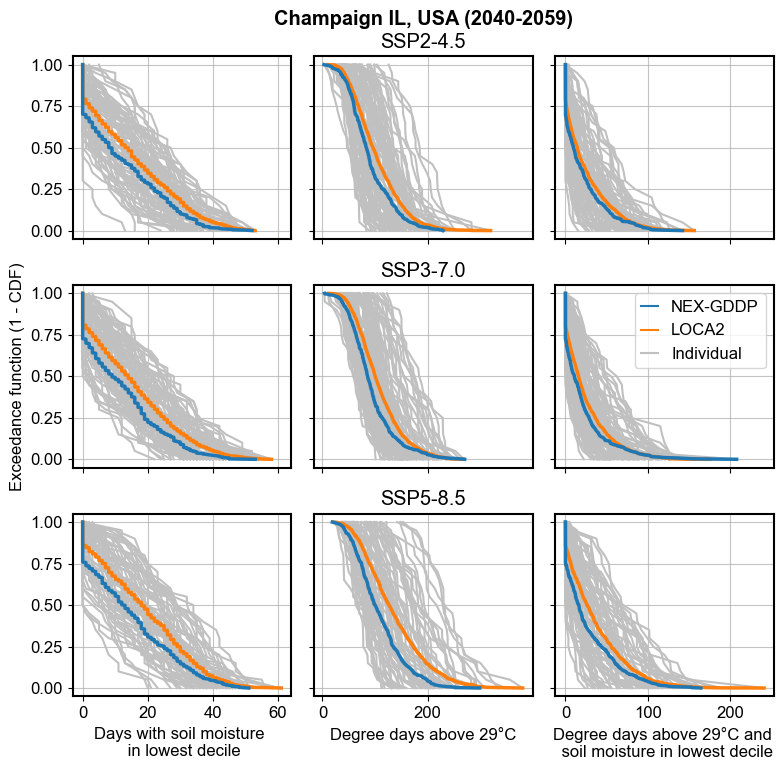

In [30]:
var_ids = ['soilMoistFrac_0-10', 'edd_29c', 'edd_29c_soilMoistFrac_0-10'] 

color_dict = {'NEX-GDDP':'C0', 'LOCA2':'C1', 'DBCCA_Daymet':'black', 'RegCM_Daymet':'black', 'RegCM_Livneh':'black','DBCCA_Livneh':'black'}

fig, axs = plt.subplots(3,3, figsize=(8,8), sharex='col', sharey=True)
for idv, var_id in enumerate(var_ids):
    for model in df.model.unique():
        for ensemble in ['NEX-GDDP', 'LOCA2']:
            for ids, ssp in enumerate(['ssp245','ssp370','ssp585']):
                df_tmp = df[(df.ensemble == ensemble) & (df.ssp == ssp) & (df.model == model)]
                if len(df_tmp.member.unique()) > 1:
                    for member in df_tmp.member.unique():
                        df_tmp_member = df_tmp[df_tmp.member == member]
                        axs[ids, idv].plot(np.sort(df_tmp_member[var_id]), 1-np.linspace(0, 1, len(df_tmp_member[var_id]), endpoint=True), color='silver')
                else:
                    axs[ids, idv].plot(np.sort(df_tmp[var_id]), 1-np.linspace(0, 1, len(df_tmp[var_id]), endpoint=True), color='silver')
                
    # Ensemble all
    for ensemble in ['LOCA2', 'NEX-GDDP']:
        for ids, ssp in enumerate(['ssp245','ssp370','ssp585']):
            df_tmp = df_tmp = df[(df.method == ensemble) & (df.ssp == ssp)]
            axs[ids, idv].plot(np.sort(df_tmp[var_id]), 1-np.linspace(0, 1, len(df_tmp[var_id]), endpoint=True),
                               color=color_dict[ensemble], lw=2.5)

# Grid
for ax in axs.flatten():
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.grid(alpha=0.75)
    
# Legend
line1, = axs[1,2].plot([-1, -2, -3], label="NEX-GDDP", color=color_dict["NEX-GDDP"])
line2, = axs[1,2].plot([-1, -2, -3], label="LOCA2", color=color_dict["LOCA2"])
line3, = axs[1,2].plot([-1, -2, -3], label="Individual", color='silver')
axs[1,2].legend(handles=[line1, line2, line3], ncol=1, fontsize=12, loc="upper right", handlelength=1)

# Set titles            
fig.suptitle('Champaign IL, USA (2040-2059)', fontweight='bold', x=0.54, y=0.96)
axs[0,1].set_title('SSP2-4.5')
axs[1,1].set_title('SSP3-7.0')
axs[2,1].set_title('SSP5-8.5')

# Set labels
axs[1,0].set_ylabel('Exceedance function (1 - CDF)')

axs[2,0].set_xlabel('Days with soil moisture \n in lowest decile')
axs[2,1].set_xlabel('Degree days above 29\N{DEGREE SIGN}C')
axs[2,2].set_xlabel('Degree days above 29\N{DEGREE SIGN}C and \n soil moisture in lowest decile')

fig.tight_layout()
plt.savefig('../figs/champaign_2040-2059_cdf.pdf')

# Underestimation plot

In [5]:
metric = "tas_prcp_dd_soilM_annual_run10avg"
year = 2050

In [6]:
# Read and select loc
lat, lon = 40.115, -88.272778
ds = xr.open_dataset(f"{main_path}/metrics/{metric}/{str(year)}.nc").sel(lat=lat, lon=lon, method='nearest')
df = ds.to_dataframe().dropna().reset_index()

In [15]:
# Subset 
df_subset = df[df.ensemble.isin(['LOCA2', 'NEX-GDDP'])]
df_subset = df_subset[df_subset.ssp != 'ssp126']

models = df_subset[['ensemble','model']].drop_duplicates().groupby('model').count().query('ensemble == 2').index
n_models = len(models)

df_subset = df_subset[df_subset.model.isin(models)]

In [311]:
#############################
# Choose SSP and metric
ssp = 'ssp370'
var_id = 'edd_29c_soilMoistFrac_0-10'
# var_id = 'soilMoistFrac'

df_subset_ssp = df_subset[df_subset.ssp == ssp]
####################

# How many re-samples
n_sim = 1000

# Total uncertainty
U_total = df_subset_ssp[var_id].max() - df_subset_ssp[var_id].min()
# U_total = df_subset_ssp[var_id].quantile(0.975) - df_subset_ssp[var_id].quantile(0.025)

# Dataframe for results
df_out = pd.DataFrame(columns=['method','n_models','model_iter','U_sample'])

# Calculate ranges
for n_model in [5,10,15,19]:
    for i_sim in range(n_sim):
        # Select models 
        random_models = np.random.choice(models, size=n_model, replace=False)
        # Loop through ensembles
        for method in ['NEX-GDDP', 'LOCA2_single', 'LOCA2_multi', 'Both']:
            # Sample
            if method.split('_')[0] == 'LOCA2':
                # Get multi-member
                df_tmp = df_subset_ssp[(df_subset_ssp.model.isin(random_models)) & (df_subset_ssp.method == 'LOCA2')]
                # Get single-member if needed
                if method.split('_')[-1] == 'single':
                    df_tmp = df_tmp.groupby('model').sample(n=1)
            elif method == 'NEX-GDDP':
                df_tmp = df_subset_ssp[(df_subset_ssp.model.isin(random_models)) & (df_subset_ssp.method == 'NEX-GDDP')]            
            elif method == 'Both':
                df_tmp = df_subset_ssp[df_subset_ssp.model.isin(random_models)]
            
            # Get uncertainty measure
            U_tmp = df_tmp[var_id].max() - df_tmp[var_id].min()
            # U_tmp = df_tmp[var_id].quantile(0.975) - df_tmp[var_id].quantile(0.025)
                
            # Append
            df_out = pd.concat([df_out, pd.DataFrame.from_dict(data={'method':[method], 'n_models':[n_model], 'model_iter':[i_sim], 'U_sample':U_tmp})])

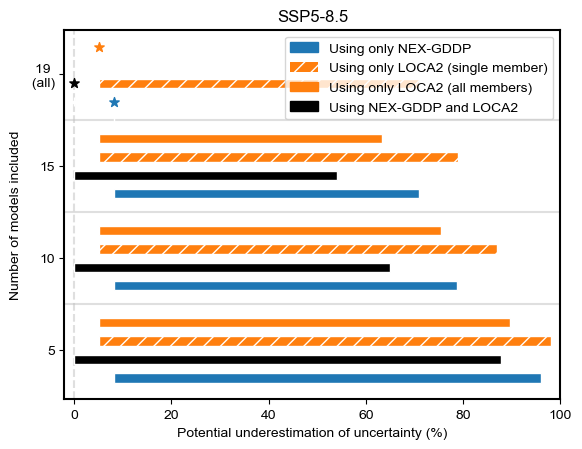

In [312]:
# Figure
plt.rcParams['hatch.color'] = 'white' 
lw=2
body_colors = {'NEX-GDDP':'C0', 'LOCA2_single':'C1', 'LOCA2_multi':'C1', 'Both':'black'}
edge_colors = {'NEX-GDDP':'white', 'LOCA2_single':'white', 'LOCA2_multi':'white', 'Both':'white'}
hatching = {'NEX-GDDP':'', 'LOCA2_single':'//', 'LOCA2_multi':'', 'Both':''}
offsets = {'NEX-GDDP':-1.5, 'LOCA2_single':0.5, 'LOCA2_multi':1.5, 'Both':-0.5}

fig, ax = plt.subplots()

df_out_maxs = pd.DataFrame(100 * (U_total - df_out.groupby(['method', 'n_models'])['U_sample'].max()) / U_total)
df_out_mins = pd.DataFrame(100 * (U_total - df_out.groupby(['method', 'n_models'])['U_sample'].min()) / U_total)

for index in df_out_maxs.index:
    method = index[0]
    n_models = index[1]
    
    ax.barh(y = n_models + offsets[method],
            width = (df_out_maxs.loc[index] - df_out_mins.loc[index]),
            left = df_out_mins.loc[index],
            color = body_colors[method],
            edgecolor = edge_colors[method],
            hatch = hatching[method],
            height = 0.5)

# Add all
for method in ['NEX-GDDP', 'LOCA2_multi']:
    ax.scatter(y = [20 + offsets[method]],
               x = [df_out_maxs.loc[(method, 19)]],
               marker='*',
               s = 50,
               color = body_colors[method])

method='Both'
ax.scatter(y = [20 + offsets[method]],
           x = [df_out_maxs.loc[(method, 19)]],
           marker='*',
           s = 50,
           color = body_colors[method])

ax.axvline(0., color='silver', ls='--', alpha=0.5, zorder=0)
ax.set_xlim([-2, 100])

ax.axhline(7.5, color='silver', alpha=0.5, zorder=0)
ax.axhline(12.5, color='silver', alpha=0.5, zorder=0)
ax.axhline(17.5, color='silver', alpha=0.5, zorder=0)

# Legend
line1 = mpatches.Patch(label="Using only NEX-GDDP", color=body_colors["NEX-GDDP"])
line2 = mpatches.Patch(label="Using only LOCA2 (single member)", hatch=r'//', facecolor=body_colors["LOCA2_single"])
line3 = mpatches.Patch(label="Using only LOCA2 (all members)", color=body_colors["LOCA2_multi"])
line4 = mpatches.Patch(label="Using NEX-GDDP and LOCA2", color=body_colors["Both"])
ax.legend(handles=[line1, line2, line3, line4], ncol=1, fontsize=10, loc="upper right")

ax.set_yticks([5,10,15,20], ['5','10','15','19 \n (all)'])
ax.set_ylabel('Number of models included')
ax.set_xlabel('Potential underestimation of uncertainty (%)')
ax.set_title('SSP5-8.5')

plt.show()

In [160]:
df_out_maxs = pd.DataFrame(100 * (1. - df_out.groupby(['method', 'n_models'])['U_sample'].max() / U_total))
df_out_mins = pd.DataFrame(100 * (1. - df_out.groupby(['method', 'n_models'])['U_sample'].min() / U_total))

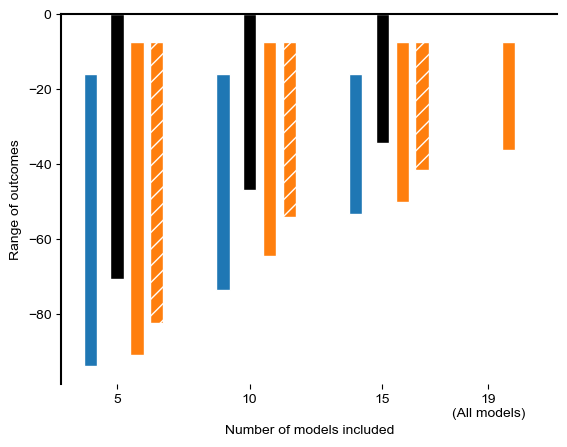

In [185]:
# Figure
lw=2
body_colors = {'NEX-GDDP':'C0', 'LOCA2_single':'C1', 'LOCA2_multi':'C1', 'Both':'black'}
edge_colors = {'NEX-GDDP':'white', 'LOCA2_single':'white', 'LOCA2_multi':'white', 'Both':'white'}
hatching = {'NEX-GDDP':'', 'LOCA2_single':'', 'LOCA2_multi':'//', 'Both':''}
offsets = {'NEX-GDDP':-1, 'LOCA2_single':0.75, 'LOCA2_multi':1.5, 'Both':0}

fig, ax = plt.subplots()

for index in df_out_maxs.index:
    method = index[0]
    n_models = index[1]
    
    ax.bar(x = n_models + offsets[method],
           height = (df_out_maxs.loc[index] - df_out_mins.loc[index]),
           bottom = -df_out_maxs.loc[index],
           color = body_colors[method],
           edgecolor = edge_colors[method],
           hatch = hatching[method],
           width = 0.5)

# Add all
for method in ['NEX-GDDP', 'LOCA2_multi', 'Both']:
    ax.scatter(x = [n_models],
              y = [])

# ax.axhline(U_total)
# ax.set_ylim([0, U_total*1.05])
ax.set_xticks([5,10,15,19], ['5','10','15','19\n(All models)'])
ax.set_xlabel('Number of models included')
ax.set_ylabel('Range of outcomes')
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# ax.grid()
plt.show()

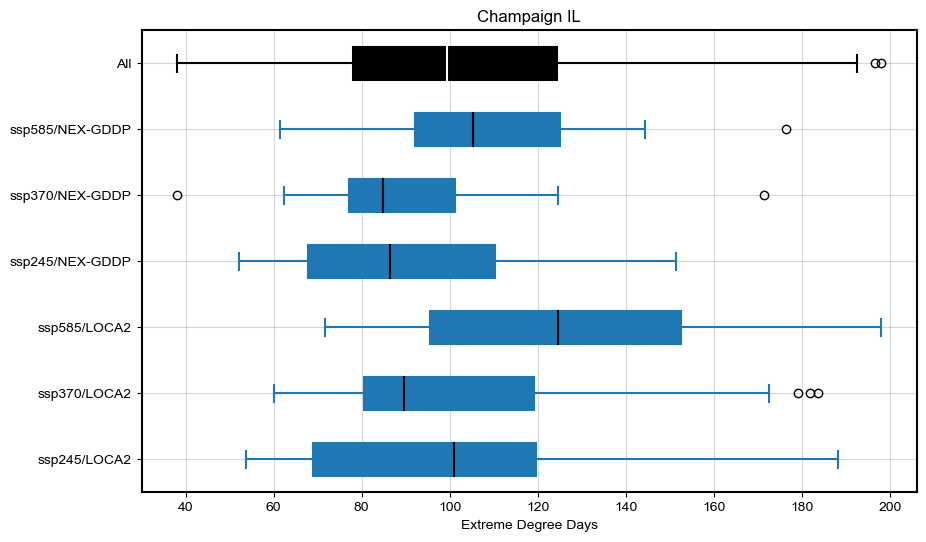

In [202]:
#############
# Make plot
#############
fig, ax = plt.subplots(figsize=(10, 6))

ax.grid(alpha=0.5)

lw = 2

colors = {
    "NEX-GDDP": "C0",
    "LOCA2": "C1",
    "DBCCA_Daymet": "C2",
    "RegCM_Daymet": "C3",
    "DBCCA_Livneh": "C4",
    "RegCM_Livneh": "C5",
}

styles = {
    "ssp126": ":",
    "ssp245": "-.",
    "ssp585": "-",
    "ssp370": "--",
}

# which df to use
df_use = df_subset.copy()

idloc = 0
labels=[]
for idm, ensemble in enumerate(df_use.ensemble.unique()):
    df_ens = df_use[df_use.ensemble == ensemble]
    for ids, ssp in enumerate(df_ens.ssp.unique()):
        idloc += 1
        labels.append(f"{ssp}/{ensemble}")
        df_plot = df_ens[df_ens.ssp == ssp]
        bplot = ax.boxplot(
                positions=[idloc],
                x=df_plot["edd_29c"],
                vert=False,
                widths=0.5,
                patch_artist=True,
                medianprops=dict(linewidth=lw - 0.5, color="black"),
                boxprops=dict(linewidth=lw - 0.5, color="C0",),
                whiskerprops=dict(linewidth=lw - 0.5, color="C0"),
                capprops=dict(linewidth=lw - 0.5, color="C0"),
                showfliers=True,
            )

        for patch in bplot["boxes"]:
            patch.set_facecolor("C0")

bplot = ax.boxplot(
    positions=[idloc+1],
    x=df_use["edd_29c"],
    vert=False,
    widths=0.5,
    patch_artist=True,
    medianprops=dict(linewidth=lw - 0.5, color="white"),
    boxprops=dict(linewidth=lw - 0.5, color="black",),
    whiskerprops=dict(linewidth=lw - 0.5, color="black"),
    capprops=dict(linewidth=lw - 0.5, color="black"),
    showfliers=True,
)
for patch in bplot["boxes"]:
            patch.set_facecolor("black")
        
labels.append("All")

ax.set_yticks(ticks=[1]+np.arange(7), labels=labels)
ax.set_xlabel("Extreme Degree Days")
ax.set_title("Champaign IL")

# ssp breaks
# ax.axvline()

# legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
# (line1,) = ax.plot([-1, -2, -3], label="NEX-GDDP", color=colors["NEX-GDDP"])
# (line2,) = ax.plot([-1, -2, -3], label="LOCA2", color=colors["LOCA2"])
# (line3,) = ax.plot([-1, -2, -3], label="DBCCA_Daymet", color=colors["DBCCA_Daymet"])
# (line4,) = ax.plot([-1, -2, -3], label="RegCM_Daymet", color=colors["RegCM_Daymet"])
# (line5,) = ax.plot([-1, -2, -3], label="DBCCA_Livneh", color=colors["DBCCA_Livneh"])
# (line6,) = ax.plot([-1, -2, -3], label="RegCM_Livneh", color=colors["RegCM_Livneh"])
# ax.legend(
#     handles=[line1, line2, line3, line4, line5, line6],
#     ncol=2,
#     fontsize=12,
#     columnspacing=0.6,
#     handletextpad=0.5,
#     handlelength=1,
# )

plt.show()

# SA results

In [3]:
metric = "soilM_edd_prcp_gs4-8_run10avg"

In [4]:
ds_uc = [xr.open_dataset(f"{main_path}/uc_results/{metric}/{str(year)}.nc") for year in range(2025,2055)]
ds_uc = xr.concat(ds_uc, dim="time")

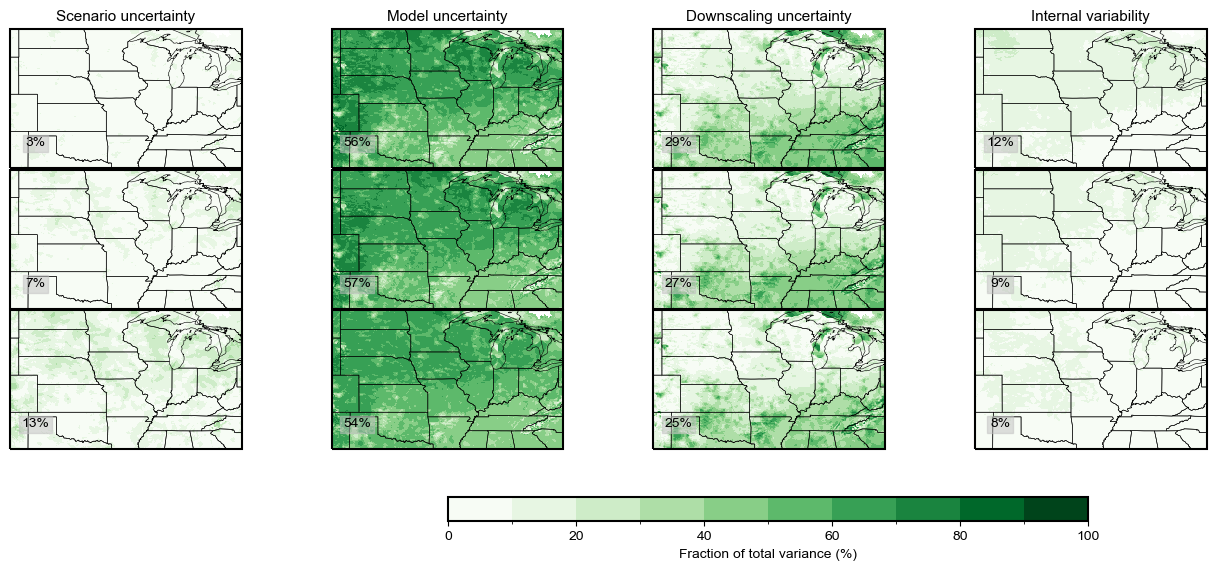

In [9]:
plot_uc_map(ds=ds_uc, var_id="gdd_10-29c", weighted=False, scenario_id="hs09", axs=0, fig=False, cbar=True, title="", fs=11)

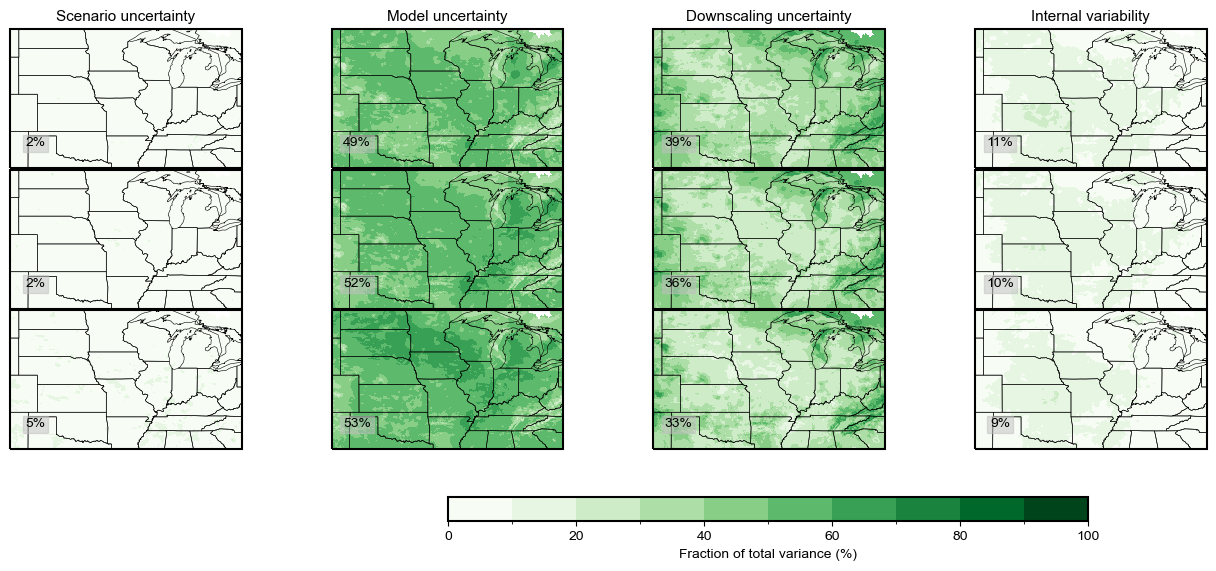

In [10]:
plot_uc_map(ds=ds_uc, var_id="edd_29c", weighted=False, scenario_id="hs09", axs=0, fig=False, cbar=True, title="", fs=11)

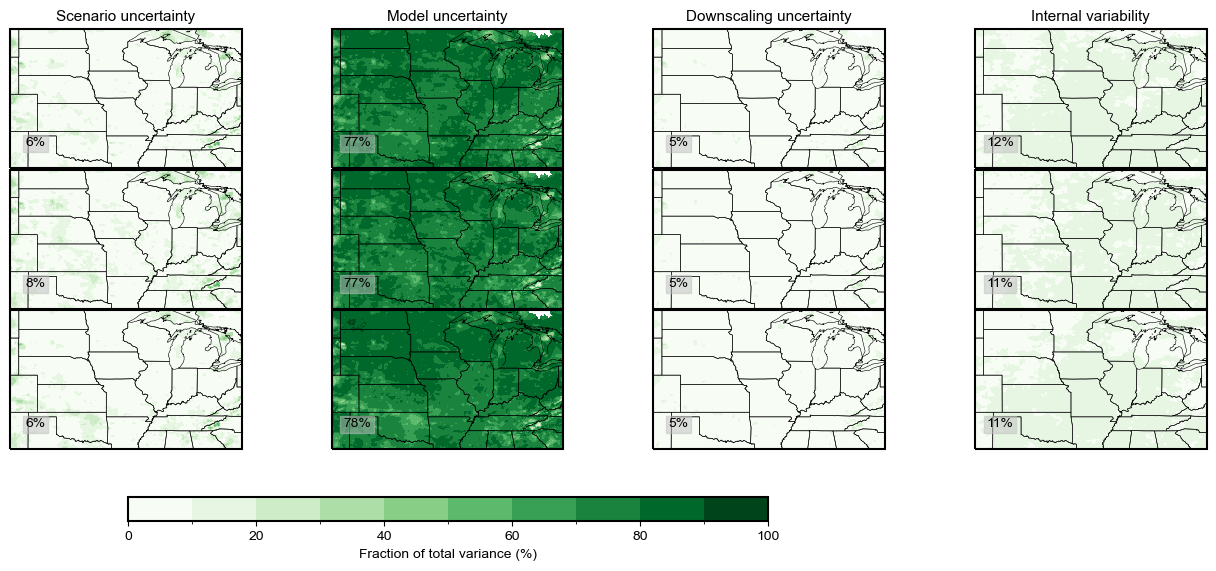

In [30]:
plot_uc_map(ds=ds_uc, var_id="prcp", weighted=False, scenario_id="hs09", axs=0, fig=False, cbar=True, title="", fs=11)

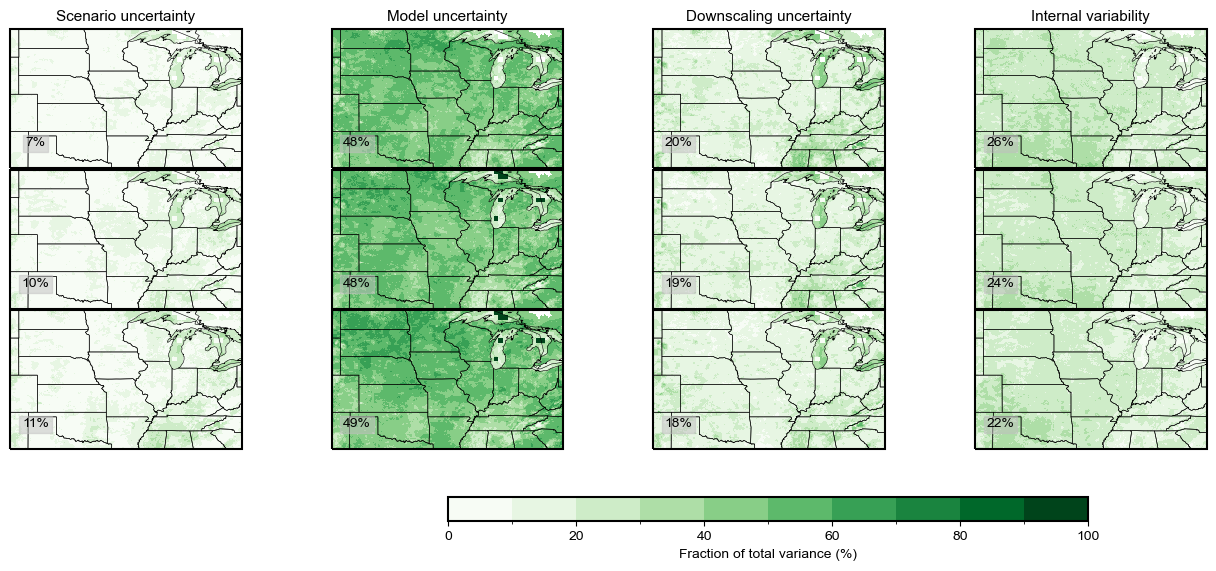

In [37]:
plot_uc_map(ds=ds_uc, var_id="soilMoistFrac", weighted=True, scenario_id="hs09", axs=0, fig=False, cbar=True, title="", fs=11)

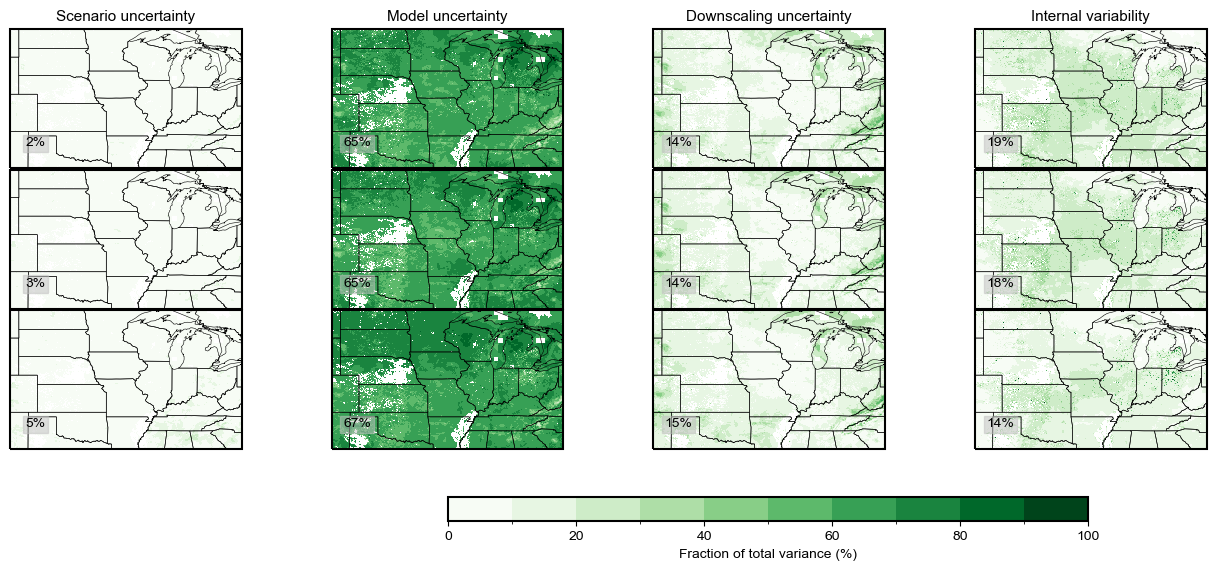

In [36]:
plot_uc_map(ds=ds_uc, var_id="edd_29c_soilMoistFrac_0-10", weighted=True, scenario_id="hs09", axs=0, fig=False, cbar=True, title="", fs=11)

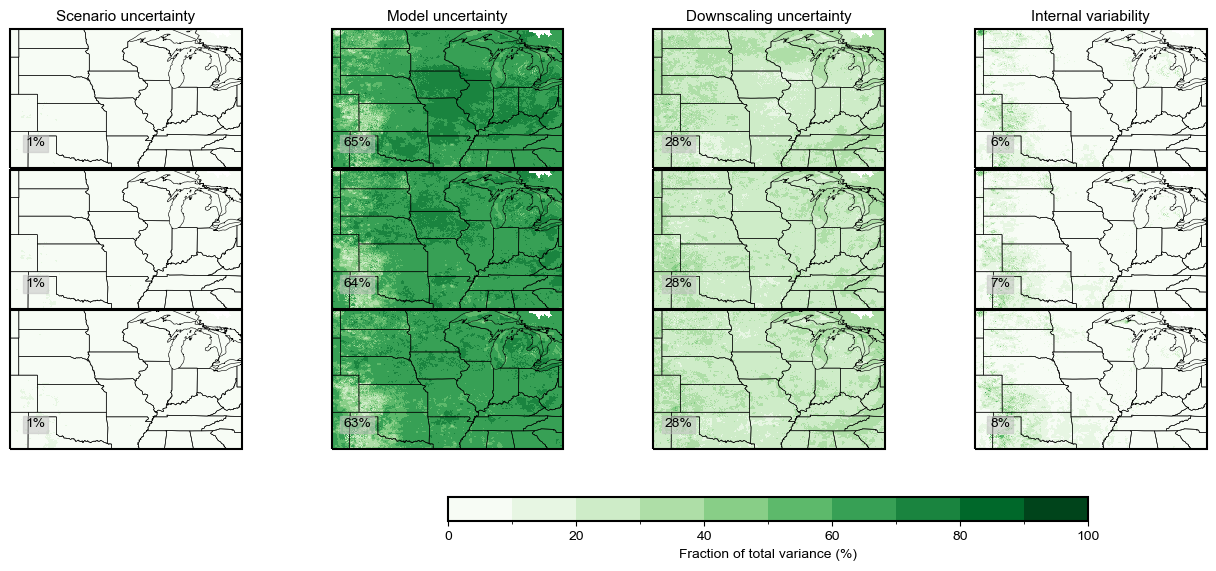

In [35]:
plot_uc_map(ds=ds_uc, var_id="edd_29c_soilMoistFrac_90-100", weighted=True, scenario_id="hs09", axs=0, fig=False, cbar=True, title="", fs=11)

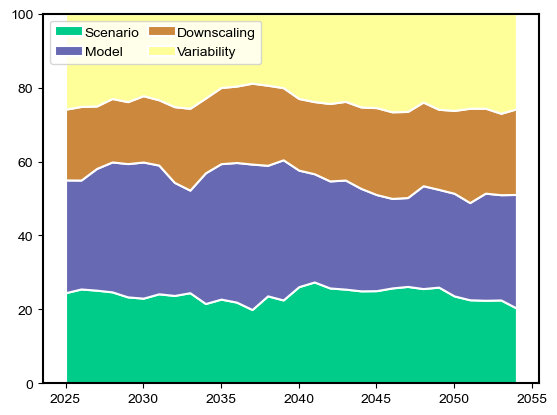

In [12]:
fig, ax = plt.subplots()

plot_uc_timeseries(
    ds_uc=ds_uc,
    var_id="prcp",
    region=[40.115, -88.272778],
    weighted=False,
    scenario_id="bb13",
    title="",
    ylabel="",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=ax)

plt.show()

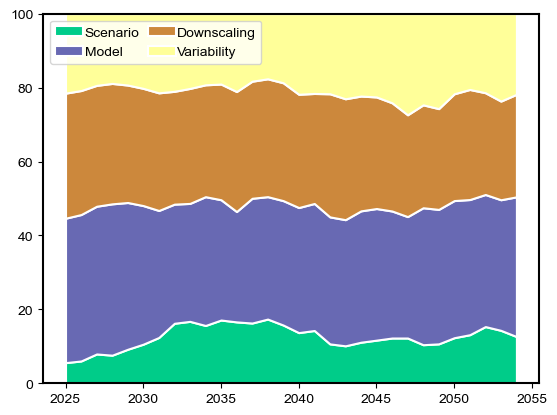

In [19]:
fig, ax = plt.subplots()

plot_uc_timeseries(
    ds_uc=ds_uc,
    var_id="soilMoistFrac",
    region=[40.115, -88.272778],
    weighted=False,
    scenario_id="hs09",
    title="",
    ylabel="",
    xlabel="",
    legend=True,
    fig_label=False,
    fig_label_height=0,
    ax=ax)

plt.show()

In [9]:
df = pd.read_csv('../data/soilM_edd_prcp_gs4-8_run10avg/champaign_2025-2054.csv')

In [26]:
df.sort_values(by='edd_29c')

,ssp,member,model,method,edd_29c,edd_29c_soilMoistFrac_0-10,prcp,gdd_10-29c,soilMoistFrac,edd_29c_soilMoistFrac_90-100,ensemble,year
251,ssp585,r1i1p1f1,INM-CM4-8,NEX-GDDP,25.305742,0.849772,634.240451,1599.575689,3.791676,0.134625,NEX-GDDP,2025
82,ssp245,r2i1p1f1,MIROC6,LOCA2,25.472361,3.312177,472.758028,1599.935441,3.168547,1.626846,LOCA2,2025
410,ssp245,r2i1p1f1,MIROC6,LOCA2,26.348968,2.190467,477.856102,1616.842815,3.133192,1.686474,LOCA2,2026
578,ssp585,r1i1p1f1,INM-CM4-8,NEX-GDDP,26.813690,0.849772,649.436638,1618.395185,3.852943,0.137133,NEX-GDDP,2026
5040,ssp370,r1i1p1f1,INM-CM4-8,NEX-GDDP,26.950720,1.992659,672.668402,1642.620911,3.747963,0.010278,NEX-GDDP,2040
...,...,...,...,...,...,...,...,...,...,...,...,...
8526,ssp126,r1i1p1f1,TaiESM1,NEX-GDDP,292.999386,76.302149,490.477789,1570.321685,3.108557,17.271483,NEX-GDDP,2051
6233,ssp126,r1i1p1f1,TaiESM1,NEX-GDDP,298.766894,90.089117,505.344493,1595.431872,3.091874,28.161118,NEX-GDDP,2044
7541,ssp126,r1i1p1f1,TaiESM1,NEX-GDDP,299.598263,88.368462,505.109332,1591.067370,3.088538,26.678348,NEX-GDDP,2048
8857,ssp126,r1i1p1f1,TaiESM1,NEX-GDDP,300.092285,82.991651,471.752151,1579.875262,3.063049,16.483250,NEX-GDDP,2052


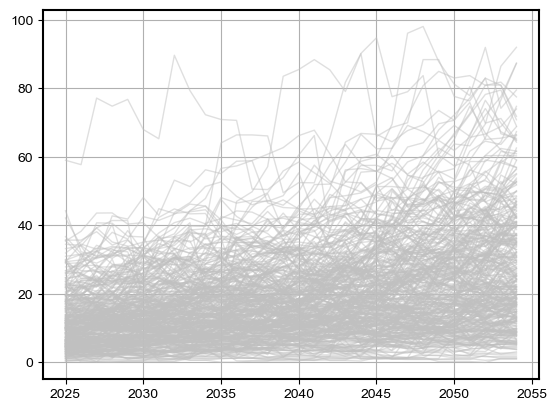

In [34]:
fig, ax = plt.subplots()
plot_timeseries(
    df=df,
    var_id="edd_29c_soilMoistFrac_0-10",
    title="",
    ylabel="",
    ylims=[False,False],
    xlabel="",
    ens_legend=False,
    ssp_legend=False,
    fig_label=False,
    ax=ax)
# ax.set_ylim([0,10])
plt.show()

In [136]:
##############################
# Timeseries plot
##############################
def plot_timeseries(
    df,
    var_id,
    title,
    ylabel,
    ylims,
    xlabel,
    ens_legend,
    ssp_legend,
    fig_label,
    ax,
):
    color_dict = {
        "NEX": "#117733",
        "CIL": "#44AA99",
        "ISIMIP": "#DDCC77",
        "GARD-SV": "#CC6677",
        "DeepSD-BC": "#882255",
    }
    line_dict = {
        "ssp585": (5, (10, 3)),
        "ssp370": "dotted",
        "ssp245": "dashed",
        "ssp126": "dashdot",
    }

    # Raw timeseries
    df_copy = df.set_index(["method", "model", "ssp", "member", "year"]).sort_index().copy()
    for method in df_copy.index.unique(level="method"):
        for model in df_copy.loc[method].index.unique(level="model"):
            for ssp in df_copy.loc[method, model].index.unique(level="ssp"):
                for member in df_copy.loc[method, model, ssp].index.unique(level="member"):
                    ax.plot(
                        df_copy.loc[method, model, ssp, member].index,
                        df_copy.loc[method, model, ssp, member][var_id],
                        alpha=0.5,
                        color="silver",
                        lw=1,
                        label=None,
                    )

#     # Ensemble-SSP means
#     df_mean = df_forced.groupby(["ensemble", "ssp", "year"]).mean(numeric_only=True)
#     df_count = df_forced[df_forced.time == 2050].drop(columns="year").groupby(["ensemble", "ssp"]).count()

#     for ensemble in df_mean.index.unique(level="ensemble"):
#         for ssp in df_mean.loc[ensemble].index.unique(level="ssp"):
#             if df_count.loc[ensemble, ssp][var_id] >= 2:
#                 ax.plot(
#                     df_mean.loc[ensemble, ssp].index,
#                     df_mean.loc[ensemble, ssp][var_id],
#                     alpha=1,
#                     color=color_dict[ensemble],
#                     ls=line_dict[ssp],
#                     lw=2,
#                     label=None,
#                 )

    # Figure settings
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.grid()
    ax.set_title(title, fontsize=11)

    if ylims[0]:
        ax.set_ylim(ylims[0], ax.get_ylim()[1])
    if ylims[1]:
        ax.set_ylim(ax.get_ylim()[0], ylims[1])

    if ens_legend:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_xlim())

        for ensemble in df_mean.index.unique(level="ensemble"):
            if df_count.loc[ensemble, "ssp370"][var_id] >= 2:
                if ensemble == "NEX":
                    ens_label = "NEX-GDDP"
                elif ensemble == "CIL":
                    ens_label = "CIL-GDPCIR"
                elif ensemble == "ISIMIP":
                    ens_label = "ISIMIP3b"
                else:
                    ens_label = ensemble
                ax.plot([0, 1], [1, 2], lw=2, color=color_dict[ensemble], label=ens_label)
        ax.legend(ncol=1, fontsize=10)

    if ssp_legend:
        ax.set_ylim(ax.get_ylim())
        ax.set_xlim(ax.get_xlim())
        for ssp in df_mean.loc["NEX"].index.unique(level="ssp"):
            ax.plot(
                [0, 1],
                [1, 2],
                lw=2,
                color="black",
                ls=line_dict[ssp],
                label=ssp[:4].upper() + "-" + ssp[4] + "." + ssp[5],
            )

        ax.legend(ncol=1, handlelength=3, fontsize=10)

    if fig_label:
        ax.text(
            0.05,
            0.05,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontweight="bold",
        )

In [6]:
##############################
# UC timeseries
##############################
def plot_uc_timeseries(
    ds_uc,
    var_id,
    region,
    weighted,
    scenario_id,
    title,
    ylabel,
    xlabel,
    legend,
    fig_label,
    fig_label_height,
    ax,
):
    """
    Region can either be a specific [lat, lon], a bounding [lat_min, lat_max, lon_min, lon_max],
    or an IPCC AR6 region name.
    """
    
    # Select var_id 
    ds_uc = ds_uc[var_id]
    
    # Select region
    if type(region) == str:
        mask = regionmask.defined_regions.ar6.land.mask(ds_uc)
        region_index = regionmask.defined_regions.ar6.land.map_keys(region)
        ds_uc_masked = ds_uc.where(mask == region_index)
    elif type(region) == list:
        if len(region) == 2:
            ds_uc_masked = ds_uc.sel(lat=region[0], lon=region[1], method="nearest")
        elif len(region) == 4:
            ds_uc_masked = ds_uc.sel(lat=slice(region[0], region[1]), lon=slice(region[2], region[3]))
    
    # Get 'total' uncertainty
    scenario_uncertainty = "scenario_" + scenario_id
    model_uncertainty = "model_" + ((not weighted) * "un") + "weighted"
    iv_uncertainty = "iv_" + ((not weighted) * "un") + "weighted"
    method_uncertainty = "method_" + ((not weighted) * "un") + "weighted"

    Utotal = (
        ds_uc_masked.sel(uncertainty=model_uncertainty)
        + ds_uc_masked.sel(uncertainty=scenario_uncertainty)
        + ds_uc_masked.sel(uncertainty=method_uncertainty)
        + ds_uc_masked.sel(uncertainty=iv_uncertainty)
    )

    # Get fractions and average for each epoch
    Ufrac_model = 100 * ds_uc_masked.sel(uncertainty=model_uncertainty) / Utotal
    Ufrac_scenario = 100 * ds_uc_masked.sel(uncertainty=scenario_uncertainty) / Utotal
    Ufrac_method = 100 * ds_uc_masked.sel(uncertainty=method_uncertainty) / Utotal
    Ufrac_iv = 100 * ds_uc_masked.sel(uncertainty=iv_uncertainty) / Utotal

    # Average over region
    if type(region) == str or (type(region) == list and len(region) == 4):
        Ufrac_model = Ufrac_model.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_scenario = Ufrac_scenario.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_method = Ufrac_method.mean(dim=["lat", "lon"], skipna=True)
        Ufrac_iv = Ufrac_iv.mean(dim=["lat", "lon"], skipna=True)

    # Construct plotting dict
    uncert_dict = {
        "Scenario": Ufrac_scenario.to_numpy().flatten(),
        "Model": Ufrac_model.to_numpy().flatten(),
        "Downscaling": Ufrac_method.to_numpy().flatten(),
        "Variability": Ufrac_iv.to_numpy().flatten(),
    }

    # Make plot
    ax.stackplot(
        np.arange(2025, 2055),
        uncert_dict.values(),
        labels=uncert_dict.keys(),
        alpha=1,
        colors=["#00CC89", "#6869B3", "#CC883C", "#FFFF99"],
        edgecolor="white",
        lw=1.5,
    )

    if legend:
        ax.legend(loc="upper left", ncol=2, columnspacing=0.6, handletextpad=0.1, fontsize=10)

    # ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylim([0, 100])
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_title(title, fontsize=11, loc="center")

    if fig_label:
        ax.text(
            0.05,
            fig_label_height,
            fig_label,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            fontweight="bold",
        )
